# Analyse predictions

In [1]:
from toolbox import *

import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import pickle
import glob
import os

In [2]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

## Load model predictions

In [3]:
gs = load_groundwater_station_data('./data/groundwater/bergstraße/gw_stations_bergstraße.csv')
gs = gs[['station_id', 'geometry']]
gs.head()

,station_id,geometry
0,12890,POINT (8.42892 49.70283)
1,12891,POINT (8.48631 49.70426)
2,12892,POINT (8.38953 49.70415)
3,12893,POINT (8.46023 49.70451)
4,12894,POINT (8.40465 49.70432)


In [4]:
pred_folder = './data/predictions'
predictions = {}

for path in glob.iglob(f'{pred_folder}/*.feather'):
    pred_name = os.path.splitext(os.path.basename(path))[0]
    print(pred_name)#, path)
    p = pd.read_feather(path)
    p = pd.merge(p, gs, how='left', on='station_id')
    predictions[pred_name] = p

avg_t+4_p-10
avg_t-4_p+10
avg_t+2_p+05
avg_t+4_p+10
past_data
avg_t0_p0


In [5]:
past = predictions['past_data'].set_index('date')
pred = predictions['avg_t+4_p-10'].set_index('date')
base = predictions['avg_t0_p0'].set_index('date')

In [6]:
past.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 424349 entries, 1971-01-04 to 2020-12-31
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   station_id                  424349 non-null  int64   
 1   ground_elev                 424349 non-null  float64 
 2   x                           424349 non-null  float64 
 3   y                           424349 non-null  float64 
 4   reg_clusters                424349 non-null  float64 
 5   ini_years_water_depth_mean  424349 non-null  float64 
 6   ini_years_water_depth_std   424349 non-null  float64 
 7   ini_years_water_depth_min   424349 non-null  float64 
 8   ini_years_water_depth_max   424349 non-null  float64 
 9   precip_mean                 424349 non-null  float64 
 10  tmean_mean                  424349 non-null  float64 
 11  moisture_mean               424349 non-null  float64 
 12  precip_mean_prev_2d_sum     424349 non-nul

## Analyze predictions over time

Must be resampled because station data begins on different dates.

In [7]:
keep_cols = ['station_id',
            'pred_water_depth',
            'tmean_mean_prev_1y_mean',
            'precip_mean_prev_1y_sum']

past_weekly = past[keep_cols + ['water_depth']].groupby(by='station_id').resample('W').mean()
pred_weekly = pred[keep_cols].groupby(by='station_id').resample('W').mean()
base_weekly = base[keep_cols].groupby(by='station_id').resample('W').mean()

In [8]:
#past_weekly

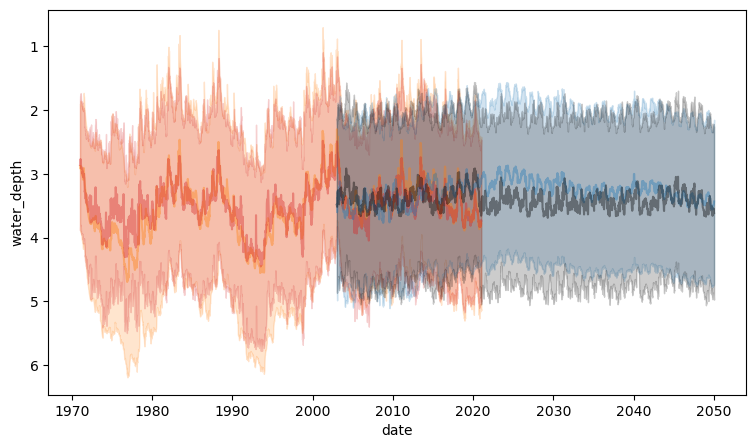

In [17]:
fig, ax = plt.subplots(figsize=(9,5))
ax.invert_yaxis()
sns.lineplot(data=past_weekly, x="date", y="water_depth", 
             errorbar='sd', color='tab:orange', alpha=0.4, ax=ax)
sns.lineplot(data=past_weekly, x="date", y="pred_water_depth", 
             errorbar='sd', color='tab:red', alpha=0.4, ax=ax)
sns.lineplot(data=pred_weekly, x="date", y="pred_water_depth", 
             errorbar='sd', color='tab:blue', alpha=0.4, ax=ax)
sns.lineplot(data=base_weekly, x="date", y="pred_water_depth", 
             errorbar='sd', color='k', alpha=0.4, ax=ax)
#ax.axhline(y=0, color='k', alpha=0.7)

#plt.xlim(pd.to_datetime('1960-01-01'), pd.to_datetime('1990-01-01'))
#plt.tight_layout()
plt.show()

In [13]:
metric = 'pred_water_depth'
anomaly = pd.DataFrame(pred_weekly[metric] - base_weekly[metric])

In [14]:
anomaly.head()

pred_water_depth
station_id date                        
12890      2003-01-05         -0.245819
           2003-01-12         -0.227232
           2003-01-19         -0.097778
           2003-01-26         -0.268409
           2003-02-02         -0.200015

### Anomalies for all stations
neg. anomaly = scenario predicts shallower water than in ref scenario

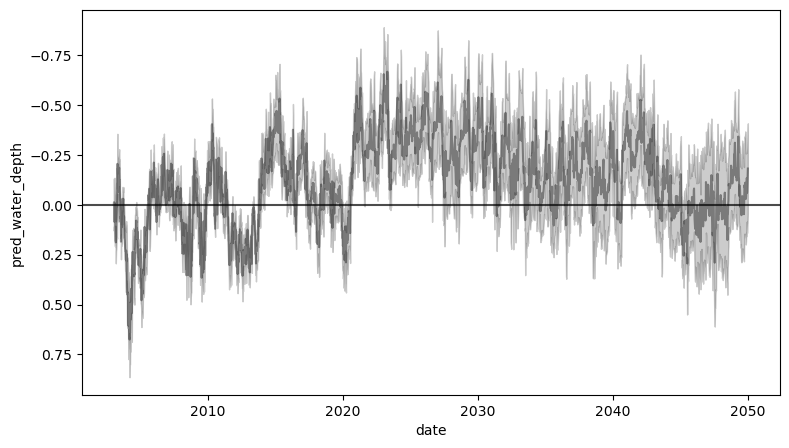

In [18]:
fig, ax = plt.subplots(figsize=(9,5))
ax.invert_yaxis()
sns.lineplot(data=anomaly, x="date", y="pred_water_depth", 
             errorbar='sd', color='k', alpha=0.4, ax=ax)
ax.axhline(y=0, color='k', alpha=0.7)